# initial coding

In [19]:
import pandas as pd

student_info = pd.read_csv('studentInfo.csv')
student_registration = pd.read_csv('studentRegistration.csv')
student_assessment = pd.read_csv('studentAssessment.csv')
student_vle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')

# EDA

In [20]:
student_info.info()
student_registration.info()
student_assessment.info()
student_vle.info()
vle.info()
assessments.info()
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
 11  final_result          32593 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Nul

In [23]:
student_info.describe(include='all')

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
count,32593,32593,3.259300e+04,32593,32593,32593,31482,32593,32593.000000,32593.000000,32593,32593
unique,7,4,NaN,2,13,5,10,3,NaN,NaN,2,4
top,BBB,2014J,NaN,M,Scotland,A Level or Equivalent,20-30%,0-35,NaN,NaN,N,Pass
freq,7909,11260,NaN,17875,3446,14045,3654,22944,NaN,NaN,29429,12361
mean,NaN,NaN,7.066877e+05,NaN,NaN,NaN,NaN,NaN,0.163225,79.758691,NaN,NaN
std,NaN,NaN,5.491673e+05,NaN,NaN,NaN,NaN,NaN,0.479758,41.071900,NaN,NaN
min,NaN,NaN,3.733000e+03,NaN,NaN,NaN,NaN,NaN,0.000000,30.000000,NaN,NaN
25%,NaN,NaN,5.085730e+05,NaN,NaN,NaN,NaN,NaN,0.000000,60.000000,NaN,NaN
50%,NaN,NaN,5.903100e+05,NaN,NaN,NaN,NaN,NaN,0.000000,60.000000,NaN,NaN
75%,NaN,NaN,6.444530e+05,NaN,NaN,NaN,NaN,NaN,0.000000,120.000000,NaN,NaN


In [25]:
student_registration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


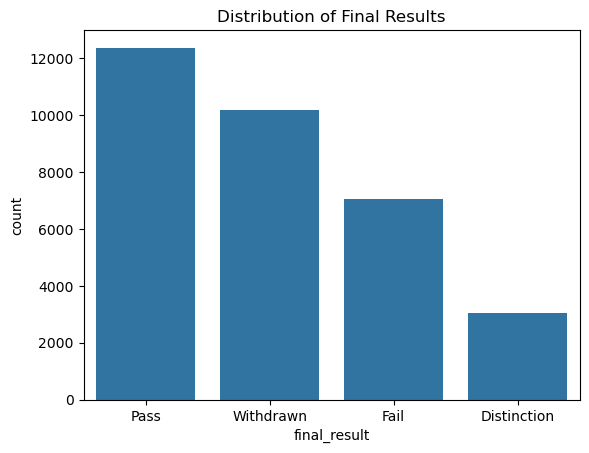

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='final_result', data=student_info)
plt.title('Distribution of Final Results')
plt.show()

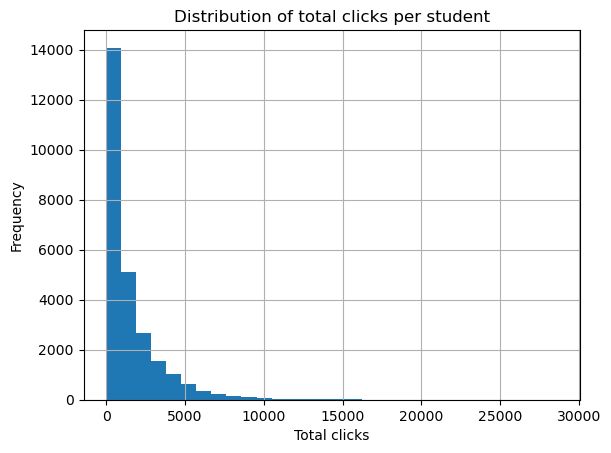

In [29]:
student_vle.groupby('id_student')['sum_click'].sum().hist(bins=30)
plt.title('Distribution of total clicks per student')
plt.xlabel('Total clicks')
plt.ylabel('Frequency')
plt.show()


# initial data pre-processing

In [33]:
static_df = student_info.merge(student_registration, on=['id_student', 'code_module', 'code_presentation'], how='left')
static_df = static_df.merge(courses, on=['code_module', 'code_presentation'], how='left')
from sklearn.model_selection import train_test_split
all_students = static_df['id_student'].unique()
dev_students, holdout_students = train_test_split(
    all_students,
    test_size=0.2,
    random_state=42
)
static_dev = static_df[static_df['id_student'].isin(dev_students)]
static_holdout = static_df[static_df['id_student'].isin(holdout_students)]

student_assessment_dev = student_assessment[student_assessment['id_student'].isin(dev_students)]
student_assessment_holdout = student_assessment[student_assessment['id_student'].isin(holdout_students)]

student_vle_dev = student_vle[student_vle['id_student'].isin(dev_students)]
student_vle_holdout = student_vle[student_vle['id_student'].isin(holdout_students)]
dev_train_ids, dev_test_ids = train_test_split(
    static_dev['id_student'].unique(),
    test_size=0.2,
    random_state=42
)

static_train = static_dev[static_dev['id_student'].isin(dev_train_ids)]
static_test = static_dev[static_dev['id_student'].isin(dev_test_ids)]
def parse_imd(x):
    if pd.isnull(x):
        return -1
    if x == 'Unknown':
        return -1
    x = x.replace('%', '')
    parts = x.split('-')
    return (int(parts[0]) + int(parts[1])) / 2


for df in [static_train, static_test]:
    df['unregistered'] = df['date_unregistration'].notnull().astype(int)
    df['final_result_bin'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)
    df['imd_band_numeric'] = df['imd_band'].apply(parse_imd)
    df['year'] = df['code_presentation'].str[:4].astype(int)
    df['term'] = df['code_presentation'].str[4]
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})
    df['disability'] = df['disability'].map({'N': 0, 'Y': 1})
    df['age_band'] = df['age_band'].map({'0-35': 0, '35-55': 1, '55<=': 2})
    df['highest_education'] = df['highest_education'].map({
        'No Formal quals': 0,
        'Lower Than A Level': 1,
        'A Level or Equivalent': 2,
        'HE Qualification': 3,
        'Post Graduate Qualification': 4
    })
    df['final_result_bin'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)
    df['registration_lead_ratio'] = (df['date_registration'] / df['module_presentation_length']).clip(upper=1)
student_assessment_train = student_assessment_dev[student_assessment_dev['id_student'].isin(dev_train_ids)]
student_assessment_test = student_assessment_dev[student_assessment_dev['id_student'].isin(dev_test_ids)]

student_vle_train = student_vle_dev[student_vle_dev['id_student'].isin(dev_train_ids)]
student_vle_test = student_vle_dev[student_vle_dev['id_student'].isin(dev_test_ids)]
def filter_vle_before(vle_df, cutoff_day=None):
    if cutoff_day is None:
        return vle_df
    return vle_df[vle_df['date'] <= cutoff_day]

def filter_assessment_before(assessment_df, cutoff_day=None):
    if cutoff_day is None:
        return assessment_df
    return assessment_df[assessment_df['date_submitted'] <= cutoff_day]
# For example, I want to simulate "prediction on the 60th day of the course"
cutoff_day = 60

student_vle_train = filter_vle_before(student_vle_train, cutoff_day=cutoff_day)
student_vle_test  = filter_vle_before(student_vle_test, cutoff_day=cutoff_day)

student_assessment_train = filter_assessment_before(student_assessment_train, cutoff_day=cutoff_day)
student_assessment_test  = filter_assessment_before(student_assessment_test, cutoff_day=cutoff_day)


C:\Users\13621\AppData\Local\Temp\ipykernel_12744\849966897.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unregistered'] = df['date_unregistration'].notnull().astype(int)
C:\Users\13621\AppData\Local\Temp\ipykernel_12744\849966897.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final_result_bin'] = df['final_result'].apply(lambda x: 1 if x == 'Withdrawn' else 0)
C:\Users\13621\AppData\Local\Temp\ipykernel_12744\849966897.py:39: SettingWithCopyWarning: 
A value is trying to be set on a co

In [35]:
def make_assessment_features(student_assessment_df, assessments_df):
    merged = student_assessment_df.merge(assessments_df, on='id_assessment', how='left')
    score_stats = merged.groupby(['id_student','code_module','code_presentation']).agg(
        mean_score=('score','mean'),
        max_score=('score','max'),
        min_score=('score','min'),
        n_submissions=('score','count')
    ).reset_index()

    missed = merged[merged['score'].isna()]
    missed_count = missed.groupby(['id_student','code_module','code_presentation']).size().reset_index(name='n_missed')

    score_features = pd.merge(score_stats, missed_count,
                              on=['id_student','code_module','code_presentation'],
                              how='left')
    score_features['n_missed'] = score_features['n_missed'].fillna(0)
    return score_features
def make_vle_features(student_vle_df, vle_df):
    vle_full = student_vle_df.merge(vle_df, on=['id_site','code_module','code_presentation'], how='left')

    # (a) Aggregates
    vle_features = vle_full.groupby(['id_student','code_module','code_presentation']).agg(
        total_clicks=('sum_click','sum'),
        active_days=('date','nunique'),
        activity_types=('activity_type','nunique')
    ).reset_index()

    # (b) Activity ratios
    activity_clicks = vle_full.groupby(
        ['id_student','code_module','code_presentation','activity_type']
    )['sum_click'].sum().unstack().fillna(0).reset_index()

    activity_cols = activity_clicks.columns.difference(['id_student','code_module','code_presentation'])
    for col in activity_cols:
        activity_clicks[f'{col}_click_ratio'] = activity_clicks[col] / activity_clicks[activity_cols].sum(axis=1).replace(0,1)

    # (c) Click times
    click_times = vle_full.groupby(['id_student','code_module','code_presentation'])['date'].agg(['min','max']).reset_index()
    click_times['first_click_lag'] = click_times['min']
    click_times['engagement_span'] = click_times['max'] - click_times['min']

    return vle_features, activity_clicks, click_times
train_assess_features = make_assessment_features(student_assessment_train, assessments)
train_vle_features, train_activity_clicks, train_click_times = make_vle_features(student_vle_train, vle)

train_data = static_train.copy()
train_data = train_data.merge(train_assess_features, on=['id_student','code_module','code_presentation'], how='left')
train_data = train_data.merge(train_vle_features, on=['id_student','code_module','code_presentation'], how='left')
train_data = train_data.merge(train_activity_clicks, on=['id_student','code_module','code_presentation'], how='left')
train_data = train_data.merge(train_click_times.drop(columns=['min','max']),
                              on=['id_student','code_module','code_presentation'], how='left')
train_data

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,page_click_ratio,questionnaire_click_ratio,quiz_click_ratio,repeatactivity_click_ratio,resource_click_ratio,sharedsubpage_click_ratio,subpage_click_ratio,url_click_ratio,first_click_lag,engagement_span
0,AAA,2013J,11391,0,East Anglian Region,3,90-100%,2,0,240,...,0.0,0.0,0.000000,0.0,0.017013,0.0,0.043478,0.001890,-5.0,59.0
1,AAA,2013J,28400,1,Scotland,3,20-30%,1,0,60,...,0.0,0.0,0.000000,0.0,0.007474,0.0,0.091181,0.047833,-10.0,63.0
2,AAA,2013J,30268,1,North Western Region,2,30-40%,1,0,60,...,0.0,0.0,0.000000,0.0,0.014235,0.0,0.078292,0.014235,-10.0,22.0
3,AAA,2013J,38053,0,Wales,2,80-90%,1,0,60,...,0.0,0.0,0.000000,0.0,0.005970,0.0,0.037811,0.015920,-10.0,70.0
4,AAA,2013J,45642,1,North Western Region,2,90-100%,0,0,120,...,0.0,0.0,0.000000,0.0,0.005068,0.0,0.087838,0.042230,-9.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20844,GGG,2014J,2608143,0,East Midlands Region,3,60-70%,1,0,30,...,0.0,0.0,0.000000,0.0,0.324324,0.0,0.108108,0.000000,9.0,39.0
20845,GGG,2014J,2620947,1,Scotland,2,80-90%,0,0,30,...,0.0,0.0,0.008929,0.0,0.151786,0.0,0.107143,0.000000,-4.0,64.0
20846,GGG,2014J,2640965,1,Wales,1,10-20,0,0,30,...,0.0,0.0,0.000000,0.0,0.097561,0.0,0.219512,0.000000,-4.0,23.0
20847,GGG,2014J,2645731,1,East Anglian Region,1,40-50%,1,0,30,...,0.0,0.0,0.000000,0.0,0.405063,0.0,0.063291,0.000000,19.0,39.0


In [37]:
test_assess_features = make_assessment_features(student_assessment_test, assessments)
test_vle_features, test_activity_clicks, test_click_times = make_vle_features(student_vle_test, vle)

test_data = static_test.copy()
test_data = test_data.merge(test_assess_features, on=['id_student','code_module','code_presentation'], how='left')
test_data = test_data.merge(test_vle_features, on=['id_student','code_module','code_presentation'], how='left')
test_data = test_data.merge(test_activity_clicks, on=['id_student','code_module','code_presentation'], how='left')
test_data = test_data.merge(test_click_times.drop(columns=['min','max']),
                            on=['id_student','code_module','code_presentation'], how='left')

In [39]:
final_train_cols = train_data.columns.tolist()
for col in final_train_cols:
    if col not in test_data.columns:
        test_data[col] = 0
test_data = test_data[final_train_cols]

In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 69 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   code_module                 5240 non-null   object 
 1   code_presentation           5240 non-null   object 
 2   id_student                  5240 non-null   int64  
 3   gender                      5240 non-null   int64  
 4   region                      5240 non-null   object 
 5   highest_education           5240 non-null   int64  
 6   imd_band                    5060 non-null   object 
 7   age_band                    5240 non-null   int64  
 8   num_of_prev_attempts        5240 non-null   int64  
 9   studied_credits             5240 non-null   int64  
 10  disability                  5240 non-null   int64  
 11  final_result                5240 non-null   object 
 12  date_registration           5236 non-null   float64
 13  date_unregistration         1617 

In [43]:
n_total_assessments = assessments.groupby(
    ['code_module', 'code_presentation']
)['id_assessment'].nunique().reset_index(name='n_total_assessments')
train_data = train_data.merge(
    n_total_assessments,
    on=['code_module', 'code_presentation'],
    how='left'
)
test_data = test_data.merge(
    n_total_assessments,
    on=['code_module', 'code_presentation'],
    how='left'
)
for df in [train_data, test_data]:
    df['assessment_completion_ratio'] = df['n_submissions'] / df['n_total_assessments'].replace(0, 1)
for df in [train_data, test_data]:
    df['has_previous_attempts'] = df.duplicated(subset=['id_student', 'code_module'], keep='first').astype(int)
vle_activity_stats = vle.groupby(
    ['code_module','code_presentation']
)['activity_type'].nunique().reset_index(name='n_activity_types')

train_data = train_data.merge(vle_activity_stats, on=['code_module','code_presentation'], how='left')
test_data = test_data.merge(vle_activity_stats, on=['code_module','code_presentation'], how='left')


In [45]:
test_data

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,resource_click_ratio,sharedsubpage_click_ratio,subpage_click_ratio,url_click_ratio,first_click_lag,engagement_span,n_total_assessments,assessment_completion_ratio,has_previous_attempts,n_activity_types
0,AAA,2013J,32885,1,West Midlands Region,1,50-60%,0,0,60,...,0.011570,0.0,0.047934,0.009917,-10.0,70.0,6,0.166667,0,9
1,AAA,2013J,77367,0,East Midlands Region,2,30-40%,0,0,60,...,0.007634,0.0,0.099237,0.045802,-10.0,69.0,6,0.333333,0,9
2,AAA,2013J,118983,0,East Midlands Region,3,30-40%,0,0,120,...,0.031496,0.0,0.220472,0.023622,-10.0,64.0,6,0.333333,0,9
3,AAA,2013J,129955,0,West Midlands Region,2,50-60%,0,0,60,...,0.005291,0.0,0.051587,0.026455,-10.0,70.0,6,0.333333,0,9
4,AAA,2013J,132976,1,East Anglian Region,1,80-90%,1,0,120,...,0.006369,0.0,0.076433,0.000000,-10.0,40.0,6,0.333333,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,GGG,2014J,2271766,1,London Region,2,30-40%,1,0,30,...,0.071429,0.0,0.000000,0.000000,2.0,43.0,10,NaN,0,7
5236,GGG,2014J,2338614,1,Scotland,2,0-10%,1,0,30,...,0.137255,0.0,0.156863,0.000000,-12.0,40.0,10,NaN,0,7
5237,GGG,2014J,2378591,1,West Midlands Region,2,30-40%,1,1,30,...,0.022222,0.0,0.111111,0.000000,31.0,12.0,10,NaN,0,7
5238,GGG,2014J,2508153,1,East Midlands Region,1,10-20,0,0,30,...,0.153846,0.0,0.121795,0.000000,-10.0,70.0,10,0.100000,0,7


In [47]:
train_data = train_data.fillna(0)
test_data = test_data.fillna(0)

In [49]:
train_data

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,resource_click_ratio,sharedsubpage_click_ratio,subpage_click_ratio,url_click_ratio,first_click_lag,engagement_span,n_total_assessments,assessment_completion_ratio,has_previous_attempts,n_activity_types
0,AAA,2013J,11391,0,East Anglian Region,3,90-100%,2,0,240,...,0.017013,0.0,0.043478,0.001890,-5.0,59.0,6,0.333333,0,9
1,AAA,2013J,28400,1,Scotland,3,20-30%,1,0,60,...,0.007474,0.0,0.091181,0.047833,-10.0,63.0,6,0.333333,0,9
2,AAA,2013J,30268,1,North Western Region,2,30-40%,1,0,60,...,0.014235,0.0,0.078292,0.014235,-10.0,22.0,6,0.000000,0,9
3,AAA,2013J,38053,0,Wales,2,80-90%,1,0,60,...,0.005970,0.0,0.037811,0.015920,-10.0,70.0,6,0.166667,0,9
4,AAA,2013J,45642,1,North Western Region,2,90-100%,0,0,120,...,0.005068,0.0,0.087838,0.042230,-9.0,66.0,6,0.333333,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20844,GGG,2014J,2608143,0,East Midlands Region,3,60-70%,1,0,30,...,0.324324,0.0,0.108108,0.000000,9.0,39.0,10,0.000000,0,7
20845,GGG,2014J,2620947,1,Scotland,2,80-90%,0,0,30,...,0.151786,0.0,0.107143,0.000000,-4.0,64.0,10,0.100000,0,7
20846,GGG,2014J,2640965,1,Wales,1,10-20,0,0,30,...,0.097561,0.0,0.219512,0.000000,-4.0,23.0,10,0.000000,0,7
20847,GGG,2014J,2645731,1,East Anglian Region,1,40-50%,1,0,30,...,0.405063,0.0,0.063291,0.000000,19.0,39.0,10,0.000000,0,7


In [53]:
train_num = train_data.select_dtypes(include=['int64', 'float64', 'int32']).copy()
train_num['code_module'] = train_data['code_module']
train_num.to_csv('processed_train_data.csv', index=False)
test_num = test_data.select_dtypes(include=['int64', 'float64', 'int32']).copy()
test_num['code_module'] = test_data['code_module']
test_num.to_csv('processed_test_data.csv', index=False)